In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path='/content/drive/MyDrive/NUSW-NB15/'

train_data = pd.read_csv(file_path + 'training-set.csv')
test_data = pd.read_csv(file_path + 'testing-set.csv')

# Combine training and testing data
combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
combined_data['target'] = combined_data['label']

In [ ]:
# Encode 'proto', 'service', 'state', and 'attack_cat'
label_encoder_proto = LabelEncoder()
label_encoder_service = LabelEncoder()
label_encoder_state = LabelEncoder()
label_encoder_attack_cat = LabelEncoder()

combined_data['proto_encoded'] = label_encoder_proto.fit_transform(combined_data['proto'])
combined_data['service_encoded'] = label_encoder_service.fit_transform(combined_data['service'])
combined_data['state_encoded'] = label_encoder_state.fit_transform(combined_data['state'])
combined_data['attack_cat'] = label_encoder_attack_cat.fit_transform(combined_data['attack_cat'])

In [ ]:
feature_columns = ['proto_encoded', 'service_encoded', 'state_encoded', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes',
                    'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
                    'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
                    'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm',
                    'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
                    'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat'] #attack_cat, label

In [ ]:
# Set 'label' as the target attribute, and other features as input features
X = combined_data[feature_columns]
y = combined_data['target']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(pd.DataFrame(X_scaled, columns=X.columns).head())
print(type(X_scaled))
print(X_scaled.shape)

   proto_encoded  service_encoded  state_encoded       dur     spkts  \
0       0.415177        -0.692762       0.742077 -0.208678 -0.130765   
1       0.415177        -0.692762       0.742077 -0.208679 -0.130765   
2       0.415177        -0.692762       0.742077 -0.208679 -0.130765   
3       0.415177        -0.692762       0.742077 -0.208679 -0.130765   
4       0.415177        -0.692762       0.742077 -0.208678 -0.130765   

      dpkts    sbytes    dbytes      rate      sttl  ...  ct_src_dport_ltm  \
0 -0.165331 -0.046480 -0.098409 -0.002151  0.722026  ...         -0.519345   
1 -0.165331 -0.039194 -0.098409  0.210460  0.722026  ...         -0.519345   
2 -0.165331 -0.043188 -0.098409  0.678204  0.722026  ...         -0.519345   
3 -0.165331 -0.044155 -0.098409  0.470318  0.722026  ...         -0.396808   
4 -0.165331 -0.037100 -0.098409  0.054546  0.722026  ...         -0.396808   

   ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0         -0.520051       -0.5685

In [ ]:
# Split training and testing data
#X_train_scaled = X_scaled[:len(train_data)]
#X_test_scaled = X_scaled[len(train_data):]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Modify the CNN model structure to fit binary classification
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 41, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 128)            24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 3, 128)            0

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reshape the data to fit the input format of the CNN
#X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
#X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Training
train_history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
2577/2577 [==============================] - 35s 12ms/step - loss: 0.1803 - accuracy: 0.9110 - val_loss: 0.1622 - val_accuracy: 0.9197
Epoch 2/20
2577/2577 [==============================] - 32s 12ms/step - loss: 0.1470 - accuracy: 0.9273 - val_loss: 0.1377 - val_accuracy: 0.9313
Epoch 3/20
2577/2577 [==============================] - 33s 13ms/step - loss: 0.1413 - accuracy: 0.9309 - val_loss: 0.1346 - val_accuracy: 0.9319
Epoch 4/20
2577/2577 [==============================] - 31s 12ms/step - loss: 0.1380 - accuracy: 0.9327 - val_loss: 0.1337 - val_accuracy: 0.9335
Epoch 5/20
2577/2577 [==============================] - 31s 12ms/step - loss: 0.1357 - accuracy: 0.9335 - val_loss: 0.1364 - val_accuracy: 0.9332
Epoch 6/20
2577/2577 [==============================] - 31s 12ms/step - loss: 0.1342 - accuracy: 0.9338 - val_loss: 0.1327 - val_accuracy: 0.9335
Epoch 7/20
2577/2577 [==============================] - 31s 12ms/step - loss: 0.1327 - accuracy: 0.9347 - val_loss: 0.1317 -

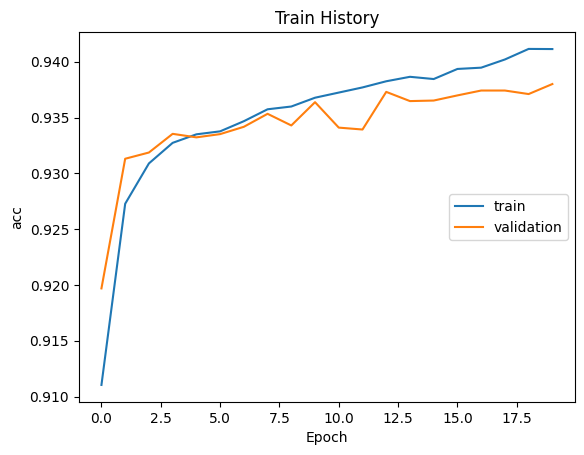

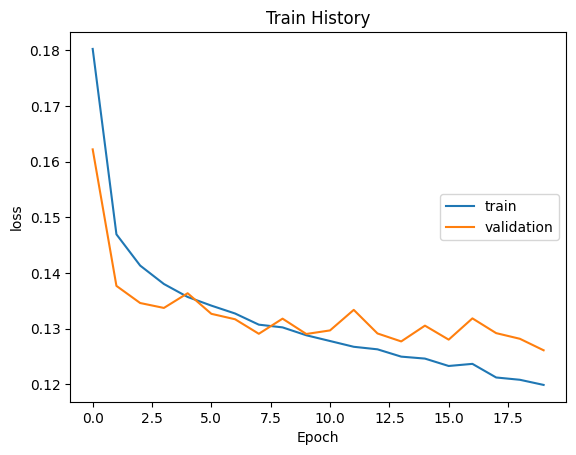

In [ ]:
def show_train_history(train_history, train, validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title('Train History')
  plt.ylabel('acc')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='center right')
  plt.show()

def show_train_history_loss(train_history, train, validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title('Train History')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='center right')
  plt.show()

import matplotlib.pyplot as plt
show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history_loss(train_history, 'loss', 'val_loss')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Use the predict method to get predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to classes (for binary classification)
y_pred = (y_pred_prob > 0.5).astype(int)

# Assuming y_test are the true labels
# y_pred are the labels predicted by the model

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.4f}%")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision * 100:.4f}%")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall * 100:.4f}%")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1 * 100:.4f} ")

# Use classification_report to show a more detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

1611/1611 [==============================] - 8s 5ms/step
Accuracy: 93.9168%
Precision: 96.0268%
Recall: 94.3640%
F1 Score: 95.1881 

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92     18675
           1       0.96      0.94      0.95     32860

    accuracy                           0.94     51535
   macro avg       0.93      0.94      0.93     51535
weighted avg       0.94      0.94      0.94     51535



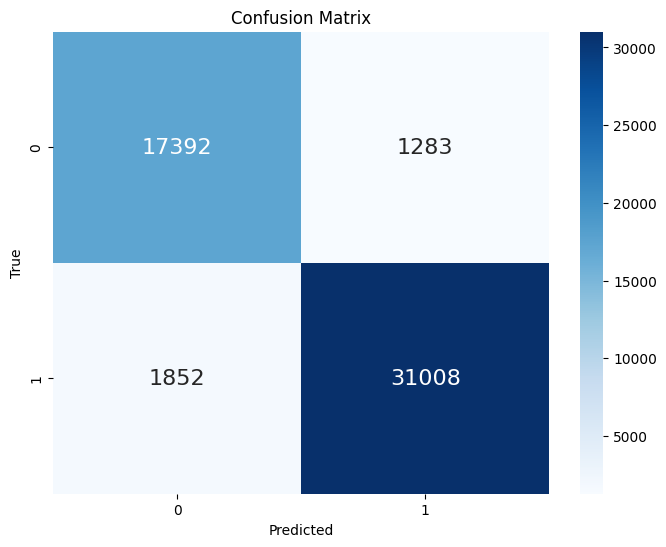

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test are the true labels
# y_pred are the labels predicted by the model

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()